In [1]:
# -------------------------------------------------------------------------------------------------
# LOAD REQUIRED LIBRARIES
# -------------------------------------------------------------------------------------------------
%matplotlib inline
import netCDF4
from distutils.util import strtobool
import pylab
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import platform
import numpy as np
import pyproj as pyproj
import datetime
import pdb
import time
import bmi.wrapper
# import pcrglobwb_203_30min_2way as pcrglobwb_bmi_v203
# from pcrglobwb_203_30min_2way import pcrglobwb_bmi
# from pcrglobwb_203_30min_2way import disclaimer
import model as pcrglobwb_bmi_v203
from model import pcrglobwb_bmi
from model import disclaimer
from coupling_PCR_FM_2way import coupling_functions
from coupling_PCR_FM_2way import model_functions
from coupling_PCR_FM_2way import utils
from coupling_PCR_FM_2way import configuration
%config Application.log_level="INFO"

/home/jannis/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# -------------------------------------------------------------------------------------------------
# IMPORT MODEL SETTINGS FROM INI-FILE/SET-FILE
# -------------------------------------------------------------------------------------------------

arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment.ini'

config = configuration.Configuration()
#config.parse_configuration_file(sys.argv[1])
config.parse_configuration_file(arg)

In [3]:
# -------------------------------------------------------------------------------------------------
# SPECIFY MODEL SETTINGS
# -------------------------------------------------------------------------------------------------

model_type = config.model_type['model_type']

use_2way = strtobool(config.general_settings['2way coupling'])

latlon = strtobool(config.general_settings['latlon'])
if latlon == False:
    inProj  = pyproj.Proj(init=config.model_settings['model_projection'])

use_Fluxes = strtobool(config.general_settings['use_Fluxes'])

use_RFS = strtobool(config.general_settings['use_RFS'])
if use_2way == True:
    use_RFS = True

verbose = strtobool(config.general_settings['verbose'])

couple_channelStorage = True

In [4]:
# -------------------------------------------------------------------------------------------------
# SPECIFY NUMERICAL SETTINGS
# -------------------------------------------------------------------------------------------------

nr_model_timesteps                    = int(config.numerical_settings['number_of_timesteps'])
update_step                           = int(config.numerical_settings['update_step'])

secPerDay                             = 86400.
end_time 							  = nr_model_timesteps * secPerDay
fraction_timestep 					  = secPerDay / update_step

threshold_inundated_depth             = float(config.numerical_settings['threshold_inundated_depth'])

# other
missing_value_landmask                = 255
missing_value_pcr                     = -999

In [5]:
nr_model_timesteps

730

In [6]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO MODELS
# -------------------------------------------------------------------------------------------------

# hydrodynamics
model_dir       	= config.model_settings['model_dir']
model_file      	= config.model_settings['model_file']
model_proj			= config.model_settings['model_projection']

# hydrology
config_pcr       	=  config.PCR_settings['config_pcr']
configPCR           = configuration.Configuration()
configPCR.parse_configuration_file(config_pcr )
inputDIR 			= configPCR.globalOptions['inputDir']
clone_pcr 			= os.path.join(inputDIR, configPCR.globalOptions['cloneMap'])
landmask_pcr 		= os.path.join(inputDIR, configPCR.globalOptions['landmask'])
LDD                 = os.path.join(inputDIR, configPCR.routingOptions['lddMap'])

In [7]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO .SO / .DLL FILES
# -------------------------------------------------------------------------------------------------

# these may be changed according to personal file and folder structure
if model_type == 'DFM':
    model_path = '/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'

elif model_type == 'LFP':
    model_path = '/home/jannis/Programmes/LISFLOODFP/lisflood-bmi-v5.9/liblisflood.so'

else:
    sys.exit('\nno adequate model defined in configuration file - define either DFM or LFP!\n')

In [8]:
# -------------------------------------------------------------------------------------------------
# INITIALIZE AND SPIN-UP PCR-GLOBWB
# -------------------------------------------------------------------------------------------------

# initiate logging and define folder for verbose-output
verbose_folder = model_functions.write2log(model_dir, model_file, latlon, use_2way, use_Fluxes, use_RFS, use_floodplain_infiltration_factor=False, adjust_initial_groundwater=False, verbose=False, moment='start')
print 'Model Start-Time: ', datetime.datetime.now()
print ''

# initiate PCR-GLOBWB
hydrologicModel = pcrglobwb_bmi_v203.pcrglobwb_bmi.pcrglobwbBMI()
hydrologicModel.initialize(config_pcr)
print '\n>>> PCR Initialized <<<\n'

# spin-up PCR-GLOBWB
hydrologicModel.spinup()

2018-02-21 13:47:21,156 model.disclaimer INFO 

 PCR-GLOBWB (PCRaster Global Water Balance) Global Hydrological Model                       

 Copyright (C) 2016, Ludovicus P. H. (Rens) van Beek, Edwin H. Sutanudjaja, Yoshihide Wada, 
 Joyce H. C. Bosmans, Niels Drost, Inge E. M. de Graaf, Kor de Jong, Patricia Lopez Lopez,  
 Stefanie Pessenteiner, Oliver Schmitz, Menno W. Straatsma, Niko Wanders, Dominik Wisser,   
 and Marc F. P. Bierkens,                                                                   
 Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands                       

 This program comes with ABSOLUTELY NO WARRANTY                                             
 This is free software, and you are welcome to redistribute it under certain conditions     
 See the LICENSE file for more details                                                      


2018-02-21 13:47:21,157 model.configuration INFO Model run started at 2018-02-21 13:47:21.146215
2018-02-21 13:


##############################
### MODEL COUPLING STARTED ###
##############################

model file chosen:  AMA_DFM_2km_1D2D.mdu
2way coupling activated:  True
lat-lon on:  True
fluxes on:  True
RFS on:  True
use floodplain infiltration factor:  False
adjust initial groundwater:  False
verbose mode on:  False

Model Start-Time:  2018-02-21 13:47:21.145738



2018-02-21 13:47:21,643 model.meteo INFO No forcing downscaling is implemented.
2018-02-21 13:47:21,785 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-02-21 13:47:21,786 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-02-21 13:47:21,788 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-02-21 13:47:21,788 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-02-21 13:47:21,789 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-02-21 13:47:21,795 model.landSurface INFO Monthly desalination water is NOT included.
2018-02-21 13:47:21,796 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-02-21 13:47:24,191 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa


>>> PCR Initialized <<<



2018-02-21 13:47:31,774 model.meteo INFO No forcing downscaling is implemented.
2018-02-21 13:47:31,919 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-02-21 13:47:31,922 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-02-21 13:47:31,924 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-02-21 13:47:31,926 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-02-21 13:47:31,929 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-02-21 13:47:31,936 model.landSurface INFO Monthly desalination water is NOT included.
2018-02-21 13:47:31,939 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-02-21 13:47:34,284 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa

2018-02-21 13:47:46,040 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-21 13:47:46,116 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-21 13:47:46,258 model.groundwater INFO Updating groundwater
2018-02-21 13:47:46,264 model.routing INFO routing in progress
2018-02-21 13:47:46,268 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:47:46,279 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:47:46,299 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:47:46,319 model.routing INFO sub-daily t

2018-02-21 13:47:48,763 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-02-21 13:47:48,843 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-02-21 13:47:48,981 model.groundwater INFO Updating groundwater
2018-02-21 13:47:48,987 model.routing INFO routing in progress
2018-02-21 13:47:48,991 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:47:49,003 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:47:49,020 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:47:49,038 model.routing INFO sub-daily t

2018-02-21 13:47:51,468 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-02-21 13:47:51,543 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-02-21 13:47:51,674 model.groundwater INFO Updating groundwater
2018-02-21 13:47:51,681 model.routing INFO routing in progress
2018-02-21 13:47:51,684 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:47:51,696 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:47:51,715 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:47:51,734 model.routing INFO sub-daily t

2018-02-21 13:47:54,142 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-02-21 13:47:54,223 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-02-21 13:47:54,354 model.groundwater INFO Updating groundwater
2018-02-21 13:47:54,360 model.routing INFO routing in progress
2018-02-21 13:47:54,363 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:47:54,374 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:47:54,392 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:47:54,410 model.routing INFO sub-daily t

2018-02-21 13:47:56,813 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-21 13:47:56,890 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-21 13:47:57,031 model.groundwater INFO Updating groundwater
2018-02-21 13:47:57,041 model.routing INFO routing in progress
2018-02-21 13:47:57,045 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:47:57,059 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:47:57,078 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:47:57,100 model.routing INFO sub-daily

2018-02-21 13:47:59,531 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-02-21 13:47:59,634 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-02-21 13:47:59,775 model.groundwater INFO Updating groundwater
2018-02-21 13:47:59,782 model.routing INFO routing in progress
2018-02-21 13:47:59,785 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:47:59,797 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:47:59,816 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:47:59,833 model.routing INFO sub-daily

2018-02-21 13:48:02,332 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-02-21 13:48:02,407 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-02-21 13:48:02,547 model.groundwater INFO Updating groundwater
2018-02-21 13:48:02,553 model.routing INFO routing in progress
2018-02-21 13:48:02,557 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:02,568 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:02,587 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:02,609 model.routing INFO sub-daily

2018-02-21 13:48:04,998 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-02-21 13:48:05,073 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-02-21 13:48:05,202 model.groundwater INFO Updating groundwater
2018-02-21 13:48:05,207 model.routing INFO routing in progress
2018-02-21 13:48:05,210 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:05,222 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:05,241 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:05,261 model.routing INFO sub-daily

2018-02-21 13:48:07,657 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-02-21 13:48:07,733 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-02-21 13:48:07,875 model.groundwater INFO Updating groundwater
2018-02-21 13:48:07,881 model.routing INFO routing in progress
2018-02-21 13:48:07,885 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:07,898 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:07,920 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:07,940 model.routing INFO sub-daily

2018-02-21 13:48:10,295 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-02-21 13:48:10,370 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-02-21 13:48:10,500 model.groundwater INFO Updating groundwater
2018-02-21 13:48:10,505 model.routing INFO routing in progress
2018-02-21 13:48:10,508 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:10,522 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:10,542 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:10,562 model.routing INFO sub-daily

2018-02-21 13:48:13,004 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-02-21 13:48:13,066 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-02-21 13:48:13,198 model.groundwater INFO Updating groundwater
2018-02-21 13:48:13,204 model.routing INFO routing in progress
2018-02-21 13:48:13,207 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:13,218 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:13,237 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:13,255 model.routing INFO sub-daily

2018-02-21 13:48:15,671 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-02-21 13:48:15,772 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-02-21 13:48:15,909 model.groundwater INFO Updating groundwater
2018-02-21 13:48:15,921 model.routing INFO routing in progress
2018-02-21 13:48:15,925 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:15,935 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:15,953 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:15,975 model.routing INFO sub-daily

2018-02-21 13:48:18,393 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-02-21 13:48:18,477 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-02-21 13:48:18,619 model.groundwater INFO Updating groundwater
2018-02-21 13:48:18,625 model.routing INFO routing in progress
2018-02-21 13:48:18,629 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:18,641 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:18,658 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:18,679 model.routing INFO sub-daily

2018-02-21 13:48:21,221 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-02-21 13:48:21,307 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-02-21 13:48:21,444 model.groundwater INFO Updating groundwater
2018-02-21 13:48:21,450 model.routing INFO routing in progress
2018-02-21 13:48:21,453 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:21,464 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:21,484 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:21,502 model.routing INFO sub-daily

2018-02-21 13:48:23,916 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-02-21 13:48:23,997 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-02-21 13:48:24,134 model.groundwater INFO Updating groundwater
2018-02-21 13:48:24,139 model.routing INFO routing in progress
2018-02-21 13:48:24,143 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:24,153 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:24,173 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:24,192 model.routing INFO sub-daily

2018-02-21 13:48:26,522 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-02-21 13:48:26,591 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-02-21 13:48:26,726 model.groundwater INFO Updating groundwater
2018-02-21 13:48:26,732 model.routing INFO routing in progress
2018-02-21 13:48:26,735 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:26,747 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:26,837 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:26,939 model.routing INFO sub-daily t

2018-02-21 13:48:31,071 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-02-21 13:48:31,154 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-02-21 13:48:31,284 model.groundwater INFO Updating groundwater
2018-02-21 13:48:31,295 model.routing INFO routing in progress
2018-02-21 13:48:31,304 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:31,317 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:31,337 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:31,357 model.routing INFO sub-daily t

2018-02-21 13:48:33,705 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-02-21 13:48:33,769 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-02-21 13:48:33,901 model.groundwater INFO Updating groundwater
2018-02-21 13:48:33,908 model.routing INFO routing in progress
2018-02-21 13:48:33,911 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:33,922 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:33,940 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:33,959 model.routing INFO sub-daily t

2018-02-21 13:48:36,439 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-02-21 13:48:36,529 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-02-21 13:48:36,680 model.groundwater INFO Updating groundwater
2018-02-21 13:48:36,686 model.routing INFO routing in progress
2018-02-21 13:48:36,690 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:36,701 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:36,720 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:36,739 model.routing INFO sub-daily t

2018-02-21 13:48:39,111 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-02-21 13:48:39,206 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-02-21 13:48:39,348 model.groundwater INFO Updating groundwater
2018-02-21 13:48:39,354 model.routing INFO routing in progress
2018-02-21 13:48:39,358 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:39,368 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:39,387 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:39,406 model.routing INFO sub-daily t

2018-02-21 13:48:41,827 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-02-21 13:48:41,914 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-02-21 13:48:42,062 model.groundwater INFO Updating groundwater
2018-02-21 13:48:42,071 model.routing INFO routing in progress
2018-02-21 13:48:42,077 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:42,092 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:42,112 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:42,133 model.routing INFO sub-daily

2018-02-21 13:48:44,555 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-02-21 13:48:44,649 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-02-21 13:48:44,788 model.groundwater INFO Updating groundwater
2018-02-21 13:48:44,795 model.routing INFO routing in progress
2018-02-21 13:48:44,798 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:44,810 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:44,830 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:44,848 model.routing INFO sub-daily

2018-02-21 13:48:47,261 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-02-21 13:48:47,359 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-02-21 13:48:47,505 model.groundwater INFO Updating groundwater
2018-02-21 13:48:47,510 model.routing INFO routing in progress
2018-02-21 13:48:47,522 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:47,540 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:47,567 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:47,585 model.routing INFO sub-daily

2018-02-21 13:48:50,000 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-02-21 13:48:50,075 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-02-21 13:48:50,204 model.groundwater INFO Updating groundwater
2018-02-21 13:48:50,213 model.routing INFO routing in progress
2018-02-21 13:48:50,230 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:50,243 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:50,263 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:50,284 model.routing INFO sub-daily

2018-02-21 13:48:52,708 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-02-21 13:48:52,792 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-02-21 13:48:52,951 model.groundwater INFO Updating groundwater
2018-02-21 13:48:52,957 model.routing INFO routing in progress
2018-02-21 13:48:52,961 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:52,976 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:52,997 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:53,025 model.routing INFO sub-daily

2018-02-21 13:48:55,475 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-02-21 13:48:55,551 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-02-21 13:48:55,703 model.groundwater INFO Updating groundwater
2018-02-21 13:48:55,713 model.routing INFO routing in progress
2018-02-21 13:48:55,716 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:55,728 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:55,747 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:55,767 model.routing INFO sub-daily

2018-02-21 13:48:58,187 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-02-21 13:48:58,264 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-02-21 13:48:58,399 model.groundwater INFO Updating groundwater
2018-02-21 13:48:58,404 model.routing INFO routing in progress
2018-02-21 13:48:58,407 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:48:58,418 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:48:58,439 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:48:58,457 model.routing INFO sub-daily

2018-02-21 13:49:00,963 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-02-21 13:49:01,052 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-02-21 13:49:01,182 model.groundwater INFO Updating groundwater
2018-02-21 13:49:01,188 model.routing INFO routing in progress
2018-02-21 13:49:01,191 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:01,202 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:01,221 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:01,248 model.routing INFO sub-daily

2018-02-21 13:49:03,715 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-02-21 13:49:03,817 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-02-21 13:49:03,969 model.groundwater INFO Updating groundwater
2018-02-21 13:49:03,976 model.routing INFO routing in progress
2018-02-21 13:49:03,981 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:03,996 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:04,019 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:04,041 model.routing INFO sub-daily

2018-02-21 13:49:06,469 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-02-21 13:49:06,551 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-02-21 13:49:06,701 model.groundwater INFO Updating groundwater
2018-02-21 13:49:06,707 model.routing INFO routing in progress
2018-02-21 13:49:06,710 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:06,720 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:06,738 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:06,760 model.routing INFO sub-daily

2018-02-21 13:49:11,246 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-02-21 13:49:11,328 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-02-21 13:49:11,441 model.groundwater INFO Updating groundwater
2018-02-21 13:49:11,445 model.routing INFO routing in progress
2018-02-21 13:49:11,449 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:11,459 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:11,475 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:11,491 model.routing INFO sub-daily t

2018-02-21 13:49:13,950 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-02-21 13:49:14,029 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-02-21 13:49:14,176 model.groundwater INFO Updating groundwater
2018-02-21 13:49:14,182 model.routing INFO routing in progress
2018-02-21 13:49:14,186 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:14,214 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:14,244 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:14,263 model.routing INFO sub-daily t

2018-02-21 13:49:16,703 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-02-21 13:49:16,786 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-02-21 13:49:16,928 model.groundwater INFO Updating groundwater
2018-02-21 13:49:16,934 model.routing INFO routing in progress
2018-02-21 13:49:16,938 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:16,949 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:16,968 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:16,986 model.routing INFO sub-daily t

2018-02-21 13:49:19,498 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-02-21 13:49:19,578 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-02-21 13:49:19,713 model.groundwater INFO Updating groundwater
2018-02-21 13:49:19,718 model.routing INFO routing in progress
2018-02-21 13:49:19,721 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:19,736 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:19,757 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:19,778 model.routing INFO sub-daily t

2018-02-21 13:49:22,332 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-02-21 13:49:22,406 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-02-21 13:49:22,537 model.groundwater INFO Updating groundwater
2018-02-21 13:49:22,543 model.routing INFO routing in progress
2018-02-21 13:49:22,547 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:22,559 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:22,578 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:22,596 model.routing INFO sub-daily

2018-02-21 13:49:25,189 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-02-21 13:49:25,279 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-02-21 13:49:25,426 model.groundwater INFO Updating groundwater
2018-02-21 13:49:25,432 model.routing INFO routing in progress
2018-02-21 13:49:25,436 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:25,454 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:25,478 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:25,497 model.routing INFO sub-daily

2018-02-21 13:49:27,841 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-02-21 13:49:27,927 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-02-21 13:49:28,062 model.groundwater INFO Updating groundwater
2018-02-21 13:49:28,068 model.routing INFO routing in progress
2018-02-21 13:49:28,072 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:28,083 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:28,102 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:28,122 model.routing INFO sub-daily

2018-02-21 13:49:30,514 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-02-21 13:49:30,591 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-02-21 13:49:30,723 model.groundwater INFO Updating groundwater
2018-02-21 13:49:30,731 model.routing INFO routing in progress
2018-02-21 13:49:30,737 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:30,749 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:30,769 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:30,789 model.routing INFO sub-daily

2018-02-21 13:49:33,148 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-02-21 13:49:33,246 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-02-21 13:49:33,394 model.groundwater INFO Updating groundwater
2018-02-21 13:49:33,404 model.routing INFO routing in progress
2018-02-21 13:49:33,410 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:33,424 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:33,449 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:33,471 model.routing INFO sub-daily

2018-02-21 13:49:36,021 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-02-21 13:49:36,094 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-02-21 13:49:36,224 model.groundwater INFO Updating groundwater
2018-02-21 13:49:36,230 model.routing INFO routing in progress
2018-02-21 13:49:36,233 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:36,243 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:36,261 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:36,280 model.routing INFO sub-daily

2018-02-21 13:49:38,700 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-02-21 13:49:38,780 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-02-21 13:49:38,921 model.groundwater INFO Updating groundwater
2018-02-21 13:49:38,934 model.routing INFO routing in progress
2018-02-21 13:49:38,938 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:38,957 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:38,985 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:39,012 model.routing INFO sub-daily

2018-02-21 13:49:41,538 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-02-21 13:49:41,622 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-02-21 13:49:41,754 model.groundwater INFO Updating groundwater
2018-02-21 13:49:41,762 model.routing INFO routing in progress
2018-02-21 13:49:41,768 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:41,781 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:41,802 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:41,820 model.routing INFO sub-daily

2018-02-21 13:49:44,199 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-02-21 13:49:44,288 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-02-21 13:49:44,438 model.groundwater INFO Updating groundwater
2018-02-21 13:49:44,444 model.routing INFO routing in progress
2018-02-21 13:49:44,448 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:44,462 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:44,482 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:44,502 model.routing INFO sub-daily

2018-02-21 13:49:46,847 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-02-21 13:49:46,908 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-02-21 13:49:47,037 model.groundwater INFO Updating groundwater
2018-02-21 13:49:47,043 model.routing INFO routing in progress
2018-02-21 13:49:47,047 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:47,060 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:47,078 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:47,097 model.routing INFO sub-daily

2018-02-21 13:49:49,502 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-02-21 13:49:49,592 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-02-21 13:49:49,733 model.groundwater INFO Updating groundwater
2018-02-21 13:49:49,751 model.routing INFO routing in progress
2018-02-21 13:49:49,754 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:49,768 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:49,789 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:49,810 model.routing INFO sub-daily

2018-02-21 13:49:52,260 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-02-21 13:49:52,341 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-02-21 13:49:52,482 model.groundwater INFO Updating groundwater
2018-02-21 13:49:52,487 model.routing INFO routing in progress
2018-02-21 13:49:52,494 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:52,507 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:52,599 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:52,691 model.routing INFO sub-daily t

2018-02-21 13:49:56,980 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-02-21 13:49:57,061 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-02-21 13:49:57,204 model.groundwater INFO Updating groundwater
2018-02-21 13:49:57,210 model.routing INFO routing in progress
2018-02-21 13:49:57,214 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:57,226 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:57,245 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:57,264 model.routing INFO sub-daily t

2018-02-21 13:49:59,654 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-02-21 13:49:59,739 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-02-21 13:49:59,879 model.groundwater INFO Updating groundwater
2018-02-21 13:49:59,888 model.routing INFO routing in progress
2018-02-21 13:49:59,895 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:49:59,909 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:49:59,931 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:49:59,954 model.routing INFO sub-daily t

2018-02-21 13:50:02,413 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-02-21 13:50:02,494 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-02-21 13:50:02,633 model.groundwater INFO Updating groundwater
2018-02-21 13:50:02,647 model.routing INFO routing in progress
2018-02-21 13:50:02,652 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:02,672 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:02,699 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:02,724 model.routing INFO sub-daily t

2018-02-21 13:50:05,129 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-02-21 13:50:05,228 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-02-21 13:50:05,395 model.groundwater INFO Updating groundwater
2018-02-21 13:50:05,408 model.routing INFO routing in progress
2018-02-21 13:50:05,412 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:05,434 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:05,463 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:05,486 model.routing INFO sub-daily t

2018-02-21 13:50:08,035 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-02-21 13:50:08,132 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-02-21 13:50:08,271 model.groundwater INFO Updating groundwater
2018-02-21 13:50:08,278 model.routing INFO routing in progress
2018-02-21 13:50:08,281 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:08,293 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:08,312 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:08,330 model.routing INFO sub-daily

2018-02-21 13:50:10,735 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-02-21 13:50:10,825 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-02-21 13:50:10,965 model.groundwater INFO Updating groundwater
2018-02-21 13:50:10,971 model.routing INFO routing in progress
2018-02-21 13:50:10,976 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:10,991 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:11,012 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:11,032 model.routing INFO sub-daily

2018-02-21 13:50:13,528 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-02-21 13:50:13,609 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-02-21 13:50:13,737 model.groundwater INFO Updating groundwater
2018-02-21 13:50:13,743 model.routing INFO routing in progress
2018-02-21 13:50:13,746 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:13,756 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:13,774 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:13,793 model.routing INFO sub-daily

2018-02-21 13:50:16,191 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-02-21 13:50:16,272 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-02-21 13:50:16,401 model.groundwater INFO Updating groundwater
2018-02-21 13:50:16,407 model.routing INFO routing in progress
2018-02-21 13:50:16,410 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:16,421 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:16,440 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:16,458 model.routing INFO sub-daily

2018-02-21 13:50:18,812 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-02-21 13:50:18,885 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-02-21 13:50:19,039 model.groundwater INFO Updating groundwater
2018-02-21 13:50:19,045 model.routing INFO routing in progress
2018-02-21 13:50:19,049 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:19,061 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:19,082 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:19,101 model.routing INFO sub-daily

2018-02-21 13:50:21,475 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-02-21 13:50:21,546 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-02-21 13:50:21,656 model.groundwater INFO Updating groundwater
2018-02-21 13:50:21,662 model.routing INFO routing in progress
2018-02-21 13:50:21,665 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:21,678 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:21,696 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:21,714 model.routing INFO sub-daily

2018-02-21 13:50:24,149 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-02-21 13:50:24,219 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-02-21 13:50:24,322 model.groundwater INFO Updating groundwater
2018-02-21 13:50:24,328 model.routing INFO routing in progress
2018-02-21 13:50:24,331 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:24,344 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:24,361 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:24,378 model.routing INFO sub-daily

2018-02-21 13:50:26,705 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-02-21 13:50:26,788 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-02-21 13:50:26,938 model.groundwater INFO Updating groundwater
2018-02-21 13:50:26,944 model.routing INFO routing in progress
2018-02-21 13:50:26,948 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:26,960 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:26,980 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:26,998 model.routing INFO sub-daily

2018-02-21 13:50:29,373 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-02-21 13:50:29,448 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-02-21 13:50:29,584 model.groundwater INFO Updating groundwater
2018-02-21 13:50:29,590 model.routing INFO routing in progress
2018-02-21 13:50:29,593 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:29,605 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:29,625 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:29,644 model.routing INFO sub-daily

2018-02-21 13:50:32,069 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-02-21 13:50:32,146 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-02-21 13:50:32,276 model.groundwater INFO Updating groundwater
2018-02-21 13:50:32,282 model.routing INFO routing in progress
2018-02-21 13:50:32,285 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:32,296 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:32,314 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:32,331 model.routing INFO sub-daily

2018-02-21 13:50:34,711 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-02-21 13:50:34,790 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-02-21 13:50:34,925 model.groundwater INFO Updating groundwater
2018-02-21 13:50:34,931 model.routing INFO routing in progress
2018-02-21 13:50:34,934 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:34,945 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:35,036 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:35,152 model.routing INFO sub-daily t

2018-02-21 13:50:39,379 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-02-21 13:50:39,458 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-02-21 13:50:39,609 model.groundwater INFO Updating groundwater
2018-02-21 13:50:39,615 model.routing INFO routing in progress
2018-02-21 13:50:39,619 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:39,645 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:39,673 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:39,692 model.routing INFO sub-daily t

2018-02-21 13:50:42,203 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-02-21 13:50:42,278 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-02-21 13:50:42,425 model.groundwater INFO Updating groundwater
2018-02-21 13:50:42,432 model.routing INFO routing in progress
2018-02-21 13:50:42,436 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:42,447 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:42,468 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:42,487 model.routing INFO sub-daily t

2018-02-21 13:50:44,977 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-02-21 13:50:45,052 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-02-21 13:50:45,181 model.groundwater INFO Updating groundwater
2018-02-21 13:50:45,187 model.routing INFO routing in progress
2018-02-21 13:50:45,190 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:45,201 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:45,217 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:45,235 model.routing INFO sub-daily t

2018-02-21 13:50:47,707 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-02-21 13:50:47,791 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-02-21 13:50:47,930 model.groundwater INFO Updating groundwater
2018-02-21 13:50:47,939 model.routing INFO routing in progress
2018-02-21 13:50:47,945 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:47,958 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:47,979 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:47,998 model.routing INFO sub-daily t

2018-02-21 13:50:50,290 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-02-21 13:50:50,360 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-02-21 13:50:50,491 model.groundwater INFO Updating groundwater
2018-02-21 13:50:50,498 model.routing INFO routing in progress
2018-02-21 13:50:50,502 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:50,523 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:50,551 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:50,571 model.routing INFO sub-daily

2018-02-21 13:50:52,995 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-02-21 13:50:53,077 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-02-21 13:50:53,215 model.groundwater INFO Updating groundwater
2018-02-21 13:50:53,221 model.routing INFO routing in progress
2018-02-21 13:50:53,224 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:53,234 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:53,255 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:53,276 model.routing INFO sub-daily

2018-02-21 13:50:55,747 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-02-21 13:50:55,822 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-02-21 13:50:55,953 model.groundwater INFO Updating groundwater
2018-02-21 13:50:55,960 model.routing INFO routing in progress
2018-02-21 13:50:55,964 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:55,975 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:55,994 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:56,012 model.routing INFO sub-daily

2018-02-21 13:50:58,401 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-02-21 13:50:58,477 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-02-21 13:50:58,606 model.groundwater INFO Updating groundwater
2018-02-21 13:50:58,613 model.routing INFO routing in progress
2018-02-21 13:50:58,616 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:50:58,627 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:50:58,646 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:50:58,664 model.routing INFO sub-daily

2018-02-21 13:51:01,097 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-02-21 13:51:01,176 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-02-21 13:51:01,316 model.groundwater INFO Updating groundwater
2018-02-21 13:51:01,325 model.routing INFO routing in progress
2018-02-21 13:51:01,330 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:01,346 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:01,366 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:01,386 model.routing INFO sub-daily

2018-02-21 13:51:03,951 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-02-21 13:51:04,052 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-02-21 13:51:04,203 model.groundwater INFO Updating groundwater
2018-02-21 13:51:04,209 model.routing INFO routing in progress
2018-02-21 13:51:04,213 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:04,225 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:04,245 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:04,265 model.routing INFO sub-daily

2018-02-21 13:51:06,690 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-02-21 13:51:06,772 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-02-21 13:51:06,937 model.groundwater INFO Updating groundwater
2018-02-21 13:51:06,944 model.routing INFO routing in progress
2018-02-21 13:51:06,948 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:06,961 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:06,981 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:06,999 model.routing INFO sub-daily

2018-02-21 13:51:09,423 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-02-21 13:51:09,512 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-02-21 13:51:09,656 model.groundwater INFO Updating groundwater
2018-02-21 13:51:09,662 model.routing INFO routing in progress
2018-02-21 13:51:09,674 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:09,693 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:09,722 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:09,752 model.routing INFO sub-daily

2018-02-21 13:51:12,321 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-02-21 13:51:12,401 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-02-21 13:51:12,536 model.groundwater INFO Updating groundwater
2018-02-21 13:51:12,542 model.routing INFO routing in progress
2018-02-21 13:51:12,545 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:12,555 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:12,573 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:12,591 model.routing INFO sub-daily

2018-02-21 13:51:14,992 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-02-21 13:51:15,065 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-02-21 13:51:15,194 model.groundwater INFO Updating groundwater
2018-02-21 13:51:15,201 model.routing INFO routing in progress
2018-02-21 13:51:15,206 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:15,216 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:15,235 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:15,253 model.routing INFO sub-daily

2018-02-21 13:51:17,743 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-02-21 13:51:17,818 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-02-21 13:51:17,947 model.groundwater INFO Updating groundwater
2018-02-21 13:51:17,953 model.routing INFO routing in progress
2018-02-21 13:51:17,956 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:17,967 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:17,983 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:18,002 model.routing INFO sub-daily

2018-02-21 13:51:22,529 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-02-21 13:51:22,610 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-02-21 13:51:22,742 model.groundwater INFO Updating groundwater
2018-02-21 13:51:22,747 model.routing INFO routing in progress
2018-02-21 13:51:22,751 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:22,761 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:22,780 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:22,797 model.routing INFO sub-daily t

2018-02-21 13:51:25,254 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-02-21 13:51:25,348 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-02-21 13:51:25,506 model.groundwater INFO Updating groundwater
2018-02-21 13:51:25,514 model.routing INFO routing in progress
2018-02-21 13:51:25,518 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:25,530 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:25,551 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:25,570 model.routing INFO sub-daily t

2018-02-21 13:51:28,029 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-02-21 13:51:28,124 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-02-21 13:51:28,258 model.groundwater INFO Updating groundwater
2018-02-21 13:51:28,266 model.routing INFO routing in progress
2018-02-21 13:51:28,270 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:28,282 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:28,302 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:28,320 model.routing INFO sub-daily t

2018-02-21 13:51:30,808 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-02-21 13:51:30,887 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-02-21 13:51:31,025 model.groundwater INFO Updating groundwater
2018-02-21 13:51:31,032 model.routing INFO routing in progress
2018-02-21 13:51:31,035 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:31,046 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:31,065 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:31,084 model.routing INFO sub-daily t

2018-02-21 13:51:33,429 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-02-21 13:51:33,505 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-02-21 13:51:33,638 model.groundwater INFO Updating groundwater
2018-02-21 13:51:33,644 model.routing INFO routing in progress
2018-02-21 13:51:33,647 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:33,657 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:33,676 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:33,693 model.routing INFO sub-daily

2018-02-21 13:51:36,181 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-02-21 13:51:36,257 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-02-21 13:51:36,389 model.groundwater INFO Updating groundwater
2018-02-21 13:51:36,395 model.routing INFO routing in progress
2018-02-21 13:51:36,398 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:36,411 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:36,429 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:36,444 model.routing INFO sub-daily

2018-02-21 13:51:38,918 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-02-21 13:51:39,014 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-02-21 13:51:39,151 model.groundwater INFO Updating groundwater
2018-02-21 13:51:39,161 model.routing INFO routing in progress
2018-02-21 13:51:39,167 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:39,180 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:39,200 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:39,221 model.routing INFO sub-daily

2018-02-21 13:51:41,653 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-02-21 13:51:41,737 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-02-21 13:51:41,886 model.groundwater INFO Updating groundwater
2018-02-21 13:51:41,892 model.routing INFO routing in progress
2018-02-21 13:51:41,896 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:41,907 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:41,927 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:41,946 model.routing INFO sub-daily

2018-02-21 13:51:44,407 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-02-21 13:51:44,494 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-02-21 13:51:44,639 model.groundwater INFO Updating groundwater
2018-02-21 13:51:44,646 model.routing INFO routing in progress
2018-02-21 13:51:44,651 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:44,671 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:44,697 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:44,716 model.routing INFO sub-daily

2018-02-21 13:51:47,191 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-02-21 13:51:47,277 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-02-21 13:51:47,417 model.groundwater INFO Updating groundwater
2018-02-21 13:51:47,423 model.routing INFO routing in progress
2018-02-21 13:51:47,427 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:47,440 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:47,460 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:47,493 model.routing INFO sub-daily

2018-02-21 13:51:49,926 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-02-21 13:51:50,004 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-02-21 13:51:50,168 model.groundwater INFO Updating groundwater
2018-02-21 13:51:50,174 model.routing INFO routing in progress
2018-02-21 13:51:50,177 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:50,188 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:50,207 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:50,226 model.routing INFO sub-daily

2018-02-21 13:51:52,691 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-02-21 13:51:52,771 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-02-21 13:51:52,908 model.groundwater INFO Updating groundwater
2018-02-21 13:51:52,915 model.routing INFO routing in progress
2018-02-21 13:51:52,918 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:52,930 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:52,950 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:52,970 model.routing INFO sub-daily

2018-02-21 13:51:55,306 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-02-21 13:51:55,384 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-02-21 13:51:55,515 model.groundwater INFO Updating groundwater
2018-02-21 13:51:55,522 model.routing INFO routing in progress
2018-02-21 13:51:55,526 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:55,538 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:55,558 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:55,577 model.routing INFO sub-daily

2018-02-21 13:51:58,111 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-02-21 13:51:58,191 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-02-21 13:51:58,344 model.groundwater INFO Updating groundwater
2018-02-21 13:51:58,362 model.routing INFO routing in progress
2018-02-21 13:51:58,371 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:51:58,395 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:51:58,426 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:51:58,451 model.routing INFO sub-daily

2018-02-21 13:52:00,960 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-02-21 13:52:01,035 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-02-21 13:52:01,166 model.groundwater INFO Updating groundwater
2018-02-21 13:52:01,177 model.routing INFO routing in progress
2018-02-21 13:52:01,180 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:01,190 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:01,212 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:01,229 model.routing INFO sub-daily

2018-02-21 13:52:05,653 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-02-21 13:52:05,728 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-02-21 13:52:05,861 model.groundwater INFO Updating groundwater
2018-02-21 13:52:05,868 model.routing INFO routing in progress
2018-02-21 13:52:05,872 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:05,883 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:05,902 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:05,920 model.routing INFO sub-daily t

2018-02-21 13:52:08,227 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-02-21 13:52:08,308 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-02-21 13:52:08,445 model.groundwater INFO Updating groundwater
2018-02-21 13:52:08,451 model.routing INFO routing in progress
2018-02-21 13:52:08,454 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:08,465 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:08,484 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:08,502 model.routing INFO sub-daily t

2018-02-21 13:52:10,969 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-02-21 13:52:11,051 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-02-21 13:52:11,193 model.groundwater INFO Updating groundwater
2018-02-21 13:52:11,200 model.routing INFO routing in progress
2018-02-21 13:52:11,203 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:11,215 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:11,235 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:11,254 model.routing INFO sub-daily t

2018-02-21 13:52:13,688 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-02-21 13:52:13,761 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-02-21 13:52:13,892 model.groundwater INFO Updating groundwater
2018-02-21 13:52:13,898 model.routing INFO routing in progress
2018-02-21 13:52:13,901 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:13,912 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:13,931 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:13,949 model.routing INFO sub-daily t

2018-02-21 13:52:16,341 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-02-21 13:52:16,429 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-02-21 13:52:16,581 model.groundwater INFO Updating groundwater
2018-02-21 13:52:16,586 model.routing INFO routing in progress
2018-02-21 13:52:16,589 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:16,599 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:16,619 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:16,637 model.routing INFO sub-daily

2018-02-21 13:52:19,051 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-02-21 13:52:19,129 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-02-21 13:52:19,260 model.groundwater INFO Updating groundwater
2018-02-21 13:52:19,266 model.routing INFO routing in progress
2018-02-21 13:52:19,275 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:19,286 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:19,305 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:19,325 model.routing INFO sub-daily

2018-02-21 13:52:21,815 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-02-21 13:52:21,902 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-02-21 13:52:22,051 model.groundwater INFO Updating groundwater
2018-02-21 13:52:22,060 model.routing INFO routing in progress
2018-02-21 13:52:22,066 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:22,081 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:22,102 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:22,125 model.routing INFO sub-daily

2018-02-21 13:52:24,580 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-02-21 13:52:24,646 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-02-21 13:52:24,747 model.groundwater INFO Updating groundwater
2018-02-21 13:52:24,753 model.routing INFO routing in progress
2018-02-21 13:52:24,756 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:24,768 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:24,784 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:24,801 model.routing INFO sub-daily

2018-02-21 13:52:27,407 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-02-21 13:52:27,490 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-02-21 13:52:27,656 model.groundwater INFO Updating groundwater
2018-02-21 13:52:27,663 model.routing INFO routing in progress
2018-02-21 13:52:27,668 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:27,681 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:27,703 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:27,730 model.routing INFO sub-daily

2018-02-21 13:52:30,194 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-02-21 13:52:30,277 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-02-21 13:52:30,421 model.groundwater INFO Updating groundwater
2018-02-21 13:52:30,426 model.routing INFO routing in progress
2018-02-21 13:52:30,430 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:30,442 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:30,460 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:30,479 model.routing INFO sub-daily

2018-02-21 13:52:33,018 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-02-21 13:52:33,109 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-02-21 13:52:33,260 model.groundwater INFO Updating groundwater
2018-02-21 13:52:33,267 model.routing INFO routing in progress
2018-02-21 13:52:33,270 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:33,282 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:33,301 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:33,322 model.routing INFO sub-daily

2018-02-21 13:52:35,659 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-02-21 13:52:35,756 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-02-21 13:52:35,897 model.groundwater INFO Updating groundwater
2018-02-21 13:52:35,903 model.routing INFO routing in progress
2018-02-21 13:52:35,907 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:35,919 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:35,938 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:35,958 model.routing INFO sub-daily

2018-02-21 13:52:38,307 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-02-21 13:52:38,389 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-02-21 13:52:38,528 model.groundwater INFO Updating groundwater
2018-02-21 13:52:38,535 model.routing INFO routing in progress
2018-02-21 13:52:38,540 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:38,554 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:38,576 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:38,595 model.routing INFO sub-daily

2018-02-21 13:52:41,034 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-02-21 13:52:41,118 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-02-21 13:52:41,260 model.groundwater INFO Updating groundwater
2018-02-21 13:52:41,266 model.routing INFO routing in progress
2018-02-21 13:52:41,269 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:41,282 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:41,301 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:41,320 model.routing INFO sub-daily

2018-02-21 13:52:43,769 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-02-21 13:52:43,856 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-02-21 13:52:44,001 model.groundwater INFO Updating groundwater
2018-02-21 13:52:44,007 model.routing INFO routing in progress
2018-02-21 13:52:44,010 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:44,022 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:44,041 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:44,060 model.routing INFO sub-daily

2018-02-21 13:52:46,485 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-02-21 13:52:46,568 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-02-21 13:52:46,709 model.groundwater INFO Updating groundwater
2018-02-21 13:52:46,715 model.routing INFO routing in progress
2018-02-21 13:52:46,718 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:46,730 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:46,822 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:46,913 model.routing INFO sub-daily t

2018-02-21 13:52:51,133 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-02-21 13:52:51,215 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-02-21 13:52:51,368 model.groundwater INFO Updating groundwater
2018-02-21 13:52:51,374 model.routing INFO routing in progress
2018-02-21 13:52:51,378 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:51,396 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:51,415 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:51,435 model.routing INFO sub-daily t

2018-02-21 13:52:54,101 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-02-21 13:52:54,185 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-02-21 13:52:54,327 model.groundwater INFO Updating groundwater
2018-02-21 13:52:54,334 model.routing INFO routing in progress
2018-02-21 13:52:54,338 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:54,350 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:54,368 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:54,385 model.routing INFO sub-daily t

2018-02-21 13:52:56,746 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-02-21 13:52:56,827 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-02-21 13:52:56,968 model.groundwater INFO Updating groundwater
2018-02-21 13:52:56,974 model.routing INFO routing in progress
2018-02-21 13:52:56,978 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:56,989 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:57,008 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:57,027 model.routing INFO sub-daily t

2018-02-21 13:52:59,449 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-02-21 13:52:59,538 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-02-21 13:52:59,679 model.groundwater INFO Updating groundwater
2018-02-21 13:52:59,688 model.routing INFO routing in progress
2018-02-21 13:52:59,699 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:52:59,712 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:52:59,734 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:52:59,753 model.routing INFO sub-daily t

2018-02-21 13:53:02,224 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-02-21 13:53:02,300 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-02-21 13:53:02,439 model.groundwater INFO Updating groundwater
2018-02-21 13:53:02,445 model.routing INFO routing in progress
2018-02-21 13:53:02,449 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:02,461 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:02,480 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:02,501 model.routing INFO sub-daily

2018-02-21 13:53:04,894 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-02-21 13:53:04,981 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-02-21 13:53:05,137 model.groundwater INFO Updating groundwater
2018-02-21 13:53:05,143 model.routing INFO routing in progress
2018-02-21 13:53:05,146 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:05,157 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:05,175 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:05,194 model.routing INFO sub-daily

2018-02-21 13:53:07,586 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-02-21 13:53:07,673 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-02-21 13:53:07,817 model.groundwater INFO Updating groundwater
2018-02-21 13:53:07,826 model.routing INFO routing in progress
2018-02-21 13:53:07,840 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:07,862 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:07,887 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:07,915 model.routing INFO sub-daily

2018-02-21 13:53:10,325 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-02-21 13:53:10,413 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-02-21 13:53:10,549 model.groundwater INFO Updating groundwater
2018-02-21 13:53:10,555 model.routing INFO routing in progress
2018-02-21 13:53:10,559 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:10,571 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:10,590 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:10,612 model.routing INFO sub-daily

2018-02-21 13:53:13,118 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-02-21 13:53:13,193 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-02-21 13:53:13,321 model.groundwater INFO Updating groundwater
2018-02-21 13:53:13,328 model.routing INFO routing in progress
2018-02-21 13:53:13,331 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:13,344 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:13,362 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:13,382 model.routing INFO sub-daily

2018-02-21 13:53:15,807 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-02-21 13:53:15,885 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-02-21 13:53:16,021 model.groundwater INFO Updating groundwater
2018-02-21 13:53:16,027 model.routing INFO routing in progress
2018-02-21 13:53:16,030 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:16,041 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:16,058 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:16,076 model.routing INFO sub-daily

2018-02-21 13:53:18,500 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-02-21 13:53:18,592 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-02-21 13:53:18,726 model.groundwater INFO Updating groundwater
2018-02-21 13:53:18,734 model.routing INFO routing in progress
2018-02-21 13:53:18,739 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:18,753 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:18,780 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:18,801 model.routing INFO sub-daily

2018-02-21 13:53:21,160 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-02-21 13:53:21,245 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-02-21 13:53:21,378 model.groundwater INFO Updating groundwater
2018-02-21 13:53:21,383 model.routing INFO routing in progress
2018-02-21 13:53:21,387 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:21,398 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:21,417 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:21,435 model.routing INFO sub-daily

2018-02-21 13:53:23,911 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-02-21 13:53:23,993 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-02-21 13:53:24,129 model.groundwater INFO Updating groundwater
2018-02-21 13:53:24,135 model.routing INFO routing in progress
2018-02-21 13:53:24,138 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:24,150 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:24,169 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:24,188 model.routing INFO sub-daily

2018-02-21 13:53:26,550 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-02-21 13:53:26,631 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-02-21 13:53:26,768 model.groundwater INFO Updating groundwater
2018-02-21 13:53:26,774 model.routing INFO routing in progress
2018-02-21 13:53:26,778 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:26,789 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:26,808 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:26,829 model.routing INFO sub-daily

2018-02-21 13:53:29,215 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-02-21 13:53:29,306 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-02-21 13:53:29,445 model.groundwater INFO Updating groundwater
2018-02-21 13:53:29,451 model.routing INFO routing in progress
2018-02-21 13:53:29,454 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:29,465 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:29,485 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:29,504 model.routing INFO sub-daily

2018-02-21 13:53:33,892 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-02-21 13:53:33,977 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-02-21 13:53:34,115 model.groundwater INFO Updating groundwater
2018-02-21 13:53:34,121 model.routing INFO routing in progress
2018-02-21 13:53:34,125 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:34,136 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:34,155 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:34,174 model.routing INFO sub-daily t

2018-02-21 13:53:36,655 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-02-21 13:53:36,737 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-02-21 13:53:36,873 model.groundwater INFO Updating groundwater
2018-02-21 13:53:36,879 model.routing INFO routing in progress
2018-02-21 13:53:36,895 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:36,917 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:36,939 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:36,959 model.routing INFO sub-daily t

2018-02-21 13:53:39,277 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-02-21 13:53:39,360 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-02-21 13:53:39,497 model.groundwater INFO Updating groundwater
2018-02-21 13:53:39,506 model.routing INFO routing in progress
2018-02-21 13:53:39,510 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:39,522 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:39,541 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:39,561 model.routing INFO sub-daily t

2018-02-21 13:53:41,991 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-02-21 13:53:42,075 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-02-21 13:53:42,212 model.groundwater INFO Updating groundwater
2018-02-21 13:53:42,219 model.routing INFO routing in progress
2018-02-21 13:53:42,230 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:42,241 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:42,259 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:42,278 model.routing INFO sub-daily t

2018-02-21 13:53:44,588 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-02-21 13:53:44,681 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-02-21 13:53:44,836 model.groundwater INFO Updating groundwater
2018-02-21 13:53:44,842 model.routing INFO routing in progress
2018-02-21 13:53:44,845 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:44,855 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:44,873 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:44,891 model.routing INFO sub-daily

2018-02-21 13:53:47,311 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-02-21 13:53:47,399 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-02-21 13:53:47,540 model.groundwater INFO Updating groundwater
2018-02-21 13:53:47,546 model.routing INFO routing in progress
2018-02-21 13:53:47,550 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:47,561 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:47,580 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:47,600 model.routing INFO sub-daily

2018-02-21 13:53:50,045 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-02-21 13:53:50,136 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-02-21 13:53:50,278 model.groundwater INFO Updating groundwater
2018-02-21 13:53:50,289 model.routing INFO routing in progress
2018-02-21 13:53:50,292 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:50,304 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:50,322 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:50,341 model.routing INFO sub-daily

2018-02-21 13:53:52,804 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-02-21 13:53:52,883 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-02-21 13:53:53,023 model.groundwater INFO Updating groundwater
2018-02-21 13:53:53,029 model.routing INFO routing in progress
2018-02-21 13:53:53,033 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:53,047 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:53,066 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:53,086 model.routing INFO sub-daily

2018-02-21 13:53:55,539 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-02-21 13:53:55,613 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-02-21 13:53:55,746 model.groundwater INFO Updating groundwater
2018-02-21 13:53:55,757 model.routing INFO routing in progress
2018-02-21 13:53:55,761 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:55,775 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:55,796 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:55,813 model.routing INFO sub-daily

2018-02-21 13:53:58,293 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-02-21 13:53:58,361 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-02-21 13:53:58,468 model.groundwater INFO Updating groundwater
2018-02-21 13:53:58,472 model.routing INFO routing in progress
2018-02-21 13:53:58,477 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:53:58,487 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:53:58,506 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:53:58,526 model.routing INFO sub-daily

2018-02-21 13:54:00,920 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-02-21 13:54:01,015 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-02-21 13:54:01,166 model.groundwater INFO Updating groundwater
2018-02-21 13:54:01,181 model.routing INFO routing in progress
2018-02-21 13:54:01,186 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:01,216 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:01,242 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:01,262 model.routing INFO sub-daily

2018-02-21 13:54:03,874 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-02-21 13:54:03,955 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-02-21 13:54:04,094 model.groundwater INFO Updating groundwater
2018-02-21 13:54:04,101 model.routing INFO routing in progress
2018-02-21 13:54:04,107 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:04,120 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:04,141 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:04,161 model.routing INFO sub-daily

2018-02-21 13:54:06,495 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-02-21 13:54:06,586 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-02-21 13:54:06,718 model.groundwater INFO Updating groundwater
2018-02-21 13:54:06,726 model.routing INFO routing in progress
2018-02-21 13:54:06,729 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:06,740 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:06,758 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:06,777 model.routing INFO sub-daily

2018-02-21 13:54:09,177 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-02-21 13:54:09,269 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-02-21 13:54:09,399 model.groundwater INFO Updating groundwater
2018-02-21 13:54:09,408 model.routing INFO routing in progress
2018-02-21 13:54:09,411 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:09,422 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:09,440 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:09,457 model.routing INFO sub-daily

2018-02-21 13:54:11,879 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-02-21 13:54:11,976 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-02-21 13:54:12,121 model.groundwater INFO Updating groundwater
2018-02-21 13:54:12,139 model.routing INFO routing in progress
2018-02-21 13:54:12,143 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:12,155 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:12,174 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:12,193 model.routing INFO sub-daily

2018-02-21 13:54:16,596 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-02-21 13:54:16,673 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-02-21 13:54:16,811 model.groundwater INFO Updating groundwater
2018-02-21 13:54:16,816 model.routing INFO routing in progress
2018-02-21 13:54:16,819 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:16,830 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:16,848 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:16,866 model.routing INFO sub-daily

2018-02-21 13:54:19,270 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-02-21 13:54:19,346 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-02-21 13:54:19,477 model.groundwater INFO Updating groundwater
2018-02-21 13:54:19,483 model.routing INFO routing in progress
2018-02-21 13:54:19,486 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:19,497 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:19,515 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:19,533 model.routing INFO sub-daily

2018-02-21 13:54:21,969 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-02-21 13:54:22,056 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-02-21 13:54:22,197 model.groundwater INFO Updating groundwater
2018-02-21 13:54:22,206 model.routing INFO routing in progress
2018-02-21 13:54:22,212 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:22,232 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:22,253 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:22,278 model.routing INFO sub-daily

2018-02-21 13:54:24,770 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-02-21 13:54:24,844 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-02-21 13:54:24,983 model.groundwater INFO Updating groundwater
2018-02-21 13:54:24,989 model.routing INFO routing in progress
2018-02-21 13:54:24,992 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:25,002 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:25,020 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:25,038 model.routing INFO sub-daily

2018-02-21 13:54:27,596 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-02-21 13:54:27,682 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-02-21 13:54:27,825 model.groundwater INFO Updating groundwater
2018-02-21 13:54:27,831 model.routing INFO routing in progress
2018-02-21 13:54:27,834 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:27,846 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:27,864 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:27,883 model.routing INFO sub-dai

2018-02-21 13:54:30,213 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-02-21 13:54:30,301 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-02-21 13:54:30,439 model.groundwater INFO Updating groundwater
2018-02-21 13:54:30,444 model.routing INFO routing in progress
2018-02-21 13:54:30,447 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:30,458 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:30,476 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:30,494 model.routing INFO sub-dai

2018-02-21 13:54:32,919 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-02-21 13:54:33,000 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-02-21 13:54:33,138 model.groundwater INFO Updating groundwater
2018-02-21 13:54:33,146 model.routing INFO routing in progress
2018-02-21 13:54:33,152 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:33,164 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:33,184 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:33,209 model.routing INFO sub-dai

2018-02-21 13:54:35,683 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-02-21 13:54:35,766 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-02-21 13:54:35,909 model.groundwater INFO Updating groundwater
2018-02-21 13:54:35,915 model.routing INFO routing in progress
2018-02-21 13:54:35,921 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:35,936 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:35,957 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:35,978 model.routing INFO sub-dai

2018-02-21 13:54:38,361 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-02-21 13:54:38,445 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-02-21 13:54:38,595 model.groundwater INFO Updating groundwater
2018-02-21 13:54:38,604 model.routing INFO routing in progress
2018-02-21 13:54:38,610 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:38,623 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:38,644 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:38,666 model.routing INFO sub-dai

2018-02-21 13:54:41,120 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-02-21 13:54:41,201 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-02-21 13:54:41,341 model.groundwater INFO Updating groundwater
2018-02-21 13:54:41,347 model.routing INFO routing in progress
2018-02-21 13:54:41,350 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:41,358 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:41,384 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:41,402 model.routing INFO sub-dai

2018-02-21 13:54:43,795 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-02-21 13:54:43,892 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-02-21 13:54:44,057 model.groundwater INFO Updating groundwater
2018-02-21 13:54:44,063 model.routing INFO routing in progress
2018-02-21 13:54:44,076 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:44,089 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:44,110 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:44,130 model.routing INFO sub-dai

2018-02-21 13:54:46,522 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-02-21 13:54:46,620 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-02-21 13:54:46,757 model.groundwater INFO Updating groundwater
2018-02-21 13:54:46,763 model.routing INFO routing in progress
2018-02-21 13:54:46,767 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:46,779 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:46,798 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:46,819 model.routing INFO sub-dai

2018-02-21 13:54:49,344 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-02-21 13:54:49,427 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-02-21 13:54:49,572 model.groundwater INFO Updating groundwater
2018-02-21 13:54:49,578 model.routing INFO routing in progress
2018-02-21 13:54:49,582 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:49,593 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:49,611 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:49,630 model.routing INFO sub-dai

2018-02-21 13:54:52,224 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-02-21 13:54:52,304 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-02-21 13:54:52,455 model.groundwater INFO Updating groundwater
2018-02-21 13:54:52,472 model.routing INFO routing in progress
2018-02-21 13:54:52,476 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:52,503 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:52,524 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:52,543 model.routing INFO sub-dai

2018-02-21 13:54:54,959 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-02-21 13:54:55,035 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-02-21 13:54:55,155 model.groundwater INFO Updating groundwater
2018-02-21 13:54:55,160 model.routing INFO routing in progress
2018-02-21 13:54:55,164 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:55,176 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:55,190 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:55,204 model.routing INFO sub-dai

2018-02-21 13:54:57,641 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-02-21 13:54:57,718 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-02-21 13:54:57,850 model.groundwater INFO Updating groundwater
2018-02-21 13:54:57,856 model.routing INFO routing in progress
2018-02-21 13:54:57,859 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:54:57,870 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:54:57,962 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:54:58,055 model.routing INFO sub-daily

2018-02-21 13:55:02,186 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-02-21 13:55:02,261 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-02-21 13:55:02,405 model.groundwater INFO Updating groundwater
2018-02-21 13:55:02,413 model.routing INFO routing in progress
2018-02-21 13:55:02,418 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:02,429 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:02,448 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:02,468 model.routing INFO sub-daily

2018-02-21 13:55:04,892 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-02-21 13:55:04,976 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-02-21 13:55:05,117 model.groundwater INFO Updating groundwater
2018-02-21 13:55:05,123 model.routing INFO routing in progress
2018-02-21 13:55:05,127 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:05,139 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:05,158 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:05,178 model.routing INFO sub-daily

2018-02-21 13:55:07,622 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-02-21 13:55:07,696 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-02-21 13:55:07,829 model.groundwater INFO Updating groundwater
2018-02-21 13:55:07,835 model.routing INFO routing in progress
2018-02-21 13:55:07,841 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:07,853 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:07,872 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:07,890 model.routing INFO sub-daily

2018-02-21 13:55:10,353 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-02-21 13:55:10,434 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-02-21 13:55:10,585 model.groundwater INFO Updating groundwater
2018-02-21 13:55:10,593 model.routing INFO routing in progress
2018-02-21 13:55:10,596 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:10,609 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:10,629 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:10,649 model.routing INFO sub-daily

2018-02-21 13:55:13,066 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-02-21 13:55:13,145 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-02-21 13:55:13,284 model.groundwater INFO Updating groundwater
2018-02-21 13:55:13,290 model.routing INFO routing in progress
2018-02-21 13:55:13,294 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:13,306 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:13,325 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:13,344 model.routing INFO sub-dai

2018-02-21 13:55:15,798 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-02-21 13:55:15,877 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-02-21 13:55:16,040 model.groundwater INFO Updating groundwater
2018-02-21 13:55:16,046 model.routing INFO routing in progress
2018-02-21 13:55:16,049 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:16,059 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:16,081 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:16,100 model.routing INFO sub-dai

2018-02-21 13:55:18,561 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-02-21 13:55:18,630 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-02-21 13:55:18,763 model.groundwater INFO Updating groundwater
2018-02-21 13:55:18,770 model.routing INFO routing in progress
2018-02-21 13:55:18,773 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:18,784 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:18,802 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:18,837 model.routing INFO sub-dai

2018-02-21 13:55:21,303 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-02-21 13:55:21,388 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-02-21 13:55:21,530 model.groundwater INFO Updating groundwater
2018-02-21 13:55:21,536 model.routing INFO routing in progress
2018-02-21 13:55:21,540 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:21,551 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:21,570 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:21,590 model.routing INFO sub-dai

2018-02-21 13:55:24,058 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-02-21 13:55:24,152 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-02-21 13:55:24,292 model.groundwater INFO Updating groundwater
2018-02-21 13:55:24,298 model.routing INFO routing in progress
2018-02-21 13:55:24,301 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:24,312 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:24,330 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:24,347 model.routing INFO sub-dai

2018-02-21 13:55:26,851 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-02-21 13:55:26,934 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-02-21 13:55:27,067 model.groundwater INFO Updating groundwater
2018-02-21 13:55:27,073 model.routing INFO routing in progress
2018-02-21 13:55:27,076 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:27,090 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:27,109 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:27,128 model.routing INFO sub-dai

2018-02-21 13:55:29,586 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-02-21 13:55:29,671 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-02-21 13:55:29,826 model.groundwater INFO Updating groundwater
2018-02-21 13:55:29,832 model.routing INFO routing in progress
2018-02-21 13:55:29,836 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:29,848 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:29,868 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:29,887 model.routing INFO sub-dai

2018-02-21 13:55:32,254 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-02-21 13:55:32,342 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-02-21 13:55:32,484 model.groundwater INFO Updating groundwater
2018-02-21 13:55:32,490 model.routing INFO routing in progress
2018-02-21 13:55:32,495 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:32,515 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:32,542 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:32,562 model.routing INFO sub-dai

2018-02-21 13:55:35,072 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-02-21 13:55:35,161 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-02-21 13:55:35,317 model.groundwater INFO Updating groundwater
2018-02-21 13:55:35,323 model.routing INFO routing in progress
2018-02-21 13:55:35,328 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:35,350 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:35,371 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:35,392 model.routing INFO sub-dai

2018-02-21 13:55:37,819 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-02-21 13:55:37,905 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-02-21 13:55:38,051 model.groundwater INFO Updating groundwater
2018-02-21 13:55:38,057 model.routing INFO routing in progress
2018-02-21 13:55:38,061 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:38,080 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:38,103 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:38,125 model.routing INFO sub-dai

2018-02-21 13:55:40,691 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-02-21 13:55:40,773 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-02-21 13:55:40,912 model.groundwater INFO Updating groundwater
2018-02-21 13:55:40,918 model.routing INFO routing in progress
2018-02-21 13:55:40,922 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:40,935 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:41,027 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:41,118 model.routing INFO sub-daily

2018-02-21 13:55:45,379 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-02-21 13:55:45,462 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-02-21 13:55:45,602 model.groundwater INFO Updating groundwater
2018-02-21 13:55:45,607 model.routing INFO routing in progress
2018-02-21 13:55:45,611 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:45,625 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:45,645 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:45,663 model.routing INFO sub-daily

2018-02-21 13:55:48,203 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-02-21 13:55:48,281 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-02-21 13:55:48,439 model.groundwater INFO Updating groundwater
2018-02-21 13:55:48,444 model.routing INFO routing in progress
2018-02-21 13:55:48,448 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:48,459 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:48,477 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:48,496 model.routing INFO sub-daily

2018-02-21 13:55:50,870 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-02-21 13:55:50,945 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-02-21 13:55:51,076 model.groundwater INFO Updating groundwater
2018-02-21 13:55:51,081 model.routing INFO routing in progress
2018-02-21 13:55:51,085 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:51,096 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:51,114 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:51,132 model.routing INFO sub-daily

2018-02-21 13:55:53,565 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-02-21 13:55:53,647 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-02-21 13:55:53,799 model.groundwater INFO Updating groundwater
2018-02-21 13:55:53,805 model.routing INFO routing in progress
2018-02-21 13:55:53,808 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:53,819 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:53,837 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:53,855 model.routing INFO sub-daily

2018-02-21 13:55:56,361 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-02-21 13:55:56,450 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-02-21 13:55:56,591 model.groundwater INFO Updating groundwater
2018-02-21 13:55:56,596 model.routing INFO routing in progress
2018-02-21 13:55:56,600 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:56,610 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:56,628 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:56,646 model.routing INFO sub-dai

2018-02-21 13:55:59,163 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-02-21 13:55:59,256 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-02-21 13:55:59,405 model.groundwater INFO Updating groundwater
2018-02-21 13:55:59,420 model.routing INFO routing in progress
2018-02-21 13:55:59,427 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:55:59,448 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:55:59,474 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:55:59,504 model.routing INFO sub-dai

2018-02-21 13:56:01,789 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-02-21 13:56:01,871 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-02-21 13:56:02,008 model.groundwater INFO Updating groundwater
2018-02-21 13:56:02,018 model.routing INFO routing in progress
2018-02-21 13:56:02,022 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:56:02,034 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:56:02,052 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:56:02,070 model.routing INFO sub-dai

2018-02-21 13:56:04,457 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-02-21 13:56:04,536 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-02-21 13:56:04,704 model.groundwater INFO Updating groundwater
2018-02-21 13:56:04,710 model.routing INFO routing in progress
2018-02-21 13:56:04,714 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:56:04,728 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:56:04,747 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:56:04,766 model.routing INFO sub-dai

2018-02-21 13:56:07,254 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-02-21 13:56:07,328 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-02-21 13:56:07,466 model.groundwater INFO Updating groundwater
2018-02-21 13:56:07,472 model.routing INFO routing in progress
2018-02-21 13:56:07,475 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:56:07,486 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:56:07,504 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:56:07,522 model.routing INFO sub-dai

2018-02-21 13:56:09,913 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-02-21 13:56:09,993 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-02-21 13:56:10,131 model.groundwater INFO Updating groundwater
2018-02-21 13:56:10,136 model.routing INFO routing in progress
2018-02-21 13:56:10,140 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:56:10,150 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:56:10,168 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:56:10,186 model.routing INFO sub-dai

2018-02-21 13:56:12,610 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-02-21 13:56:12,697 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-02-21 13:56:12,836 model.groundwater INFO Updating groundwater
2018-02-21 13:56:12,844 model.routing INFO routing in progress
2018-02-21 13:56:12,848 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:56:12,865 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:56:12,896 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:56:12,924 model.routing INFO sub-dai

2018-02-21 13:56:15,392 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-02-21 13:56:15,469 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-02-21 13:56:15,610 model.groundwater INFO Updating groundwater
2018-02-21 13:56:15,618 model.routing INFO routing in progress
2018-02-21 13:56:15,625 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:56:15,637 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:56:15,656 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:56:15,674 model.routing INFO sub-dai

2018-02-21 13:56:18,072 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-02-21 13:56:18,158 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-02-21 13:56:18,314 model.groundwater INFO Updating groundwater
2018-02-21 13:56:18,323 model.routing INFO routing in progress
2018-02-21 13:56:18,333 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:56:18,346 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:56:18,368 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:56:18,390 model.routing INFO sub-dai

2018-02-21 13:56:20,837 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-02-21 13:56:20,921 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-02-21 13:56:21,100 model.groundwater INFO Updating groundwater
2018-02-21 13:56:21,109 model.routing INFO routing in progress
2018-02-21 13:56:21,113 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:56:21,128 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:56:21,150 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:56:21,172 model.routing INFO sub-dai

2018-02-21 13:56:23,642 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-02-21 13:56:23,712 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-02-21 13:56:23,838 model.groundwater INFO Updating groundwater
2018-02-21 13:56:23,845 model.routing INFO routing in progress
2018-02-21 13:56:23,848 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 13:56:23,857 model.routing INFO sub-daily time step 1 from 24
2018-02-21 13:56:23,871 model.routing INFO sub-daily time step 2 from 24
2018-02-21 13:56:23,890 model.routing INFO sub-dai

2018-02-21 13:56:24,408 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 13:56:24,410 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 13:56:24,411 model.pcrglobwb INFO Accumulated totalPotentialMaximumNonIrrGrossDemand days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 13:56:24,412 model.pcrglobwb INFO Accumulated irrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 13:56:24,413 model.pcrglobwb INFO Accumulated irrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 13:56:24,413 model.pcrglobwb INFO Accumulated domesticWaterWithdrawal days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 13:56:24,414 model.pcrglobwb INFO Accumulated industryWaterWithdrawal days 1 to 366 in 1984 = 0.000000

In [9]:
# -------------------------------------------------------------------------------------------------
# INITIALIZING HYDRODYNAMIC MODEL
# -------------------------------------------------------------------------------------------------

# initiate hydraulic model
hydrodynamicModel = bmi.wrapper.BMIWrapper(engine = model_path, configfile = (os.path.join(model_dir, model_file)))
hydrodynamicModel.initialize()
print '\n>>> ',model_type,' Initialized <<<\n'

2018-02-21 13:56:30,643 bmi.wrapper INFO Loading library from path /home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
2018-02-21 13:56:30,663 bmi.wrapper INFO Loading model /home/jannis/Desktop/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM/AMA_DFM_2km_1D2D.mdu in directory /home/jannis/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM



>>>  DFM  Initialized <<<



In [10]:
# -------------------------------------------------------------------------------------------------
# EXCTRACTING RELEVANT DATA FROM MODELS
# -------------------------------------------------------------------------------------------------

if model_type == 'DFM':

    #- retrieving data from Delft3D FM
    bottom_lvl_1D, bottom_lvl_2D, cellAreaSpherical_1D, cellAreaSpherical_2D, \
        hydrodynamic_coords_1D, hydrodynamic_coords_2D, separator_1D  = model_functions.extractModelData_DFM(hydrodynamicModel, 
                                                                                                             use_RFS, 
                                                                                                             use_2way)

    coupledFPindices = 0.
    print '\n>>> DFM data retrieved <<<\n'

#- computing PCR-coordinates
cellarea_data_pcr, landmask_data_pcr, clone_data_pcr = model_functions.extractModelData_PCR(hydrologicModel, 
                                                                                            landmask_pcr, 
                                                                                            clone_pcr)
PCRcoords = coupling_functions.getPCRcoords(landmask_data_pcr)
print '\n>>> PCR data retrieved <<<\n'


>>> DFM data retrieved <<<


>>> PCR data retrieved <<<



In [11]:
# -------------------------------------------------------------------------------------------------
# ACTIVATING COUPLING FOR RELEVANT PCR SECTIONS
# -------------------------------------------------------------------------------------------------

hydrologicModel.set_var(('grassland','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('forest','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('routing','ActivateCoupling'), 'True')
hydrologicModel.set_var(('WaterBodies', 'ActivateCoupling'), 'True')

In [12]:
# -------------------------------------------------------------------------------------------------
# COUPLING THE GRIDS
# -------------------------------------------------------------------------------------------------

# linking PCR-cells with 1D hydrodynamic cells (since use_RFS=True)
couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                  hydrodynamic_coords_1D, 
                                                                                                  verbose)
# linking PCR-cells with 2D hydrodynamic cells
couple_HDYN_2_HLOG_2way, couple_HLOG_2_HDYN_2way, coupled_HLOG_indices_2way = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                                 hydrodynamic_coords_2D, 
                                                                                                                 verbose)


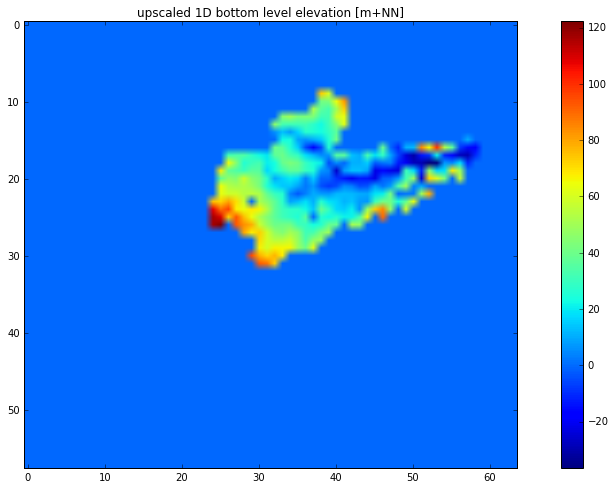

In [13]:
bottomElevation_HDYN1D_2_HLOG_BMI = model_functions.determine_bottomElev1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                         coupled_HLOG_indices,
                                                                                         bottom_lvl_1D,
                                                                                         landmask_pcr)

plt.figure(figsize=(16,8))
plt.title('upscaled 1D bottom level elevation [m+NN]')
plt.imshow(bottomElevation_HDYN1D_2_HLOG_BMI)
plt.colorbar()

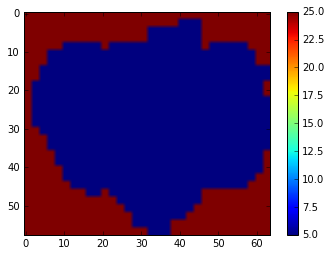

In [14]:
# -------------------------------------------------------------------------------------------------
# TURNING OFF ROUTING BY PCR IN COUPLED AREA
# -------------------------------------------------------------------------------------------------

newLDD = model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

plt.figure()
plt.imshow(newLDD)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'coupledLDD.png'), dpi=300)

In [15]:
current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
current_water_depth_1D = current_water_depth[separator_1D:]
current_water_depth_2D = current_water_depth[:separator_1D]

In [16]:
inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               cellarea_data_pcr,
                                                                                               landmask_pcr)

In [17]:
inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

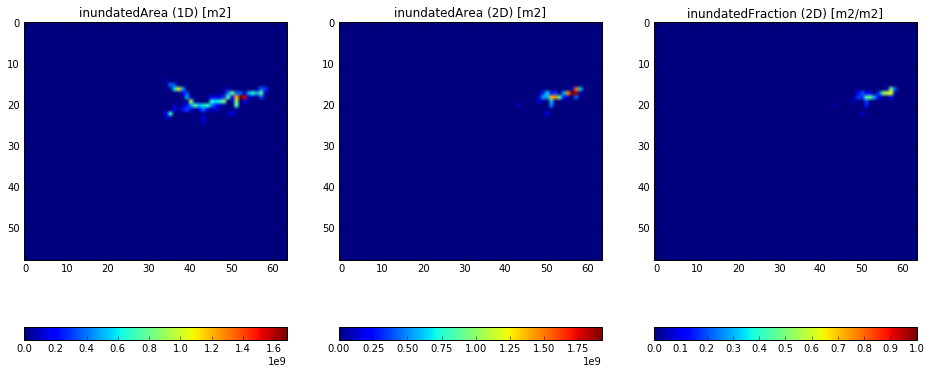

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedAreaAndFraction_HDYN_2_HLOG_BMI.png'), dpi=300)

In [19]:
current_water_volume = np.copy(hydrodynamicModel.get_var('vol1')) # all hydrodyancmi cells
current_water_volume_1D = current_water_volume[separator_1D:] # 1D channel cells
current_water_volume_2D = current_water_volume[:separator_1D] # 2D floodplain cells

In [20]:
waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

In [21]:
waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

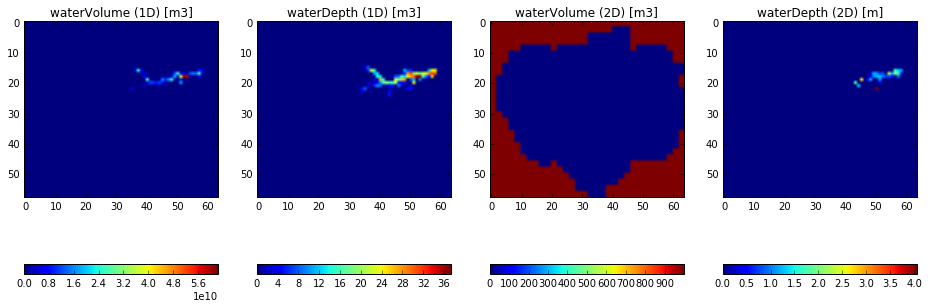

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

In [23]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

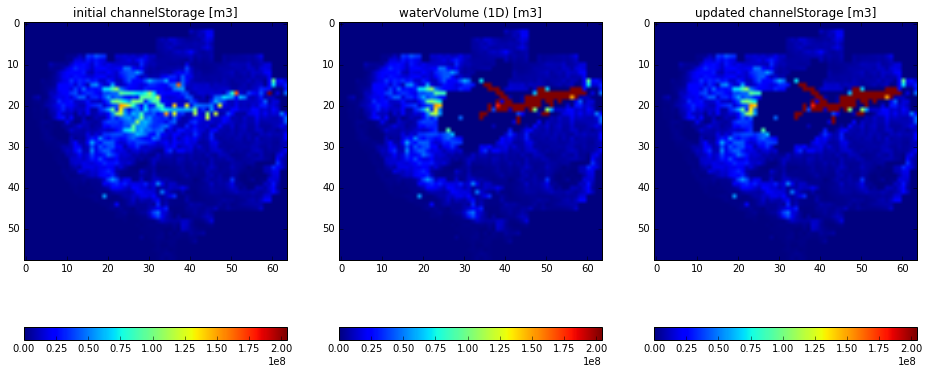

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [25]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

max fWL 4.05598413266


In [26]:
hydrologicModel.update(1)

2018-02-21 13:57:29,951 model.pcrglobwb INFO Reading forcings for time 1984-01-01
2018-02-21 13:57:30,508 model.pcrglobwb INFO Updating model for time 1984-01-01
2018-02-21 13:57:30,705 model.landSurface INFO Updating land cover: forest
2018-02-21 13:57:30,711 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/Global_CropCoefficientKc-Forest_30min.nc ; variable: kc !!!!!!
The date 1984-01-01 is NOT available. The date 2000-1-1 is used.

2018-02-21 13:57:30,902 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/interceptCapInputForest366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-01 is NOT available. The date 2000-1-1 is used.

2018-02-21 13:57:31,085 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/coverFractionInputForest366days.nc ; variable: cov

In [27]:
#waterVolume_HDYN2D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)


delta volume of all PCR cells before feedback from DFM: 3.71E+10
feedback volume from FM: 1.30E+06 
delta volume of all PCR cells after feedback from DFM: 3.71E+10
reduction by  0.0 %
delta volume for PCR cells coupled to hydrodynamic channels 2.23E+10


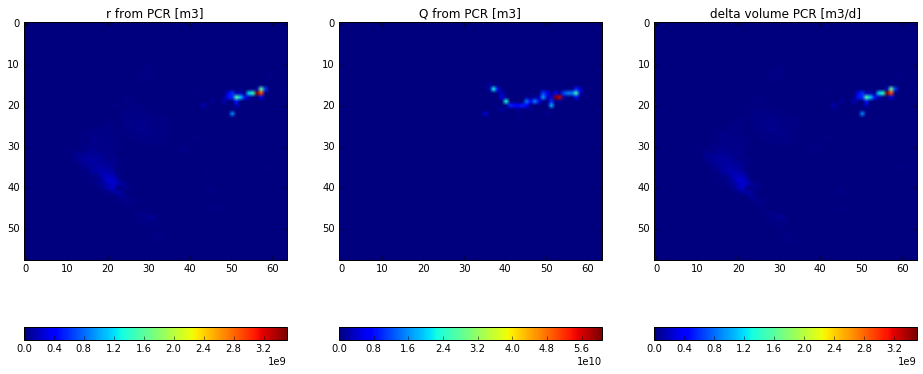

In [28]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = -999
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = -999

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [29]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

In [30]:
model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

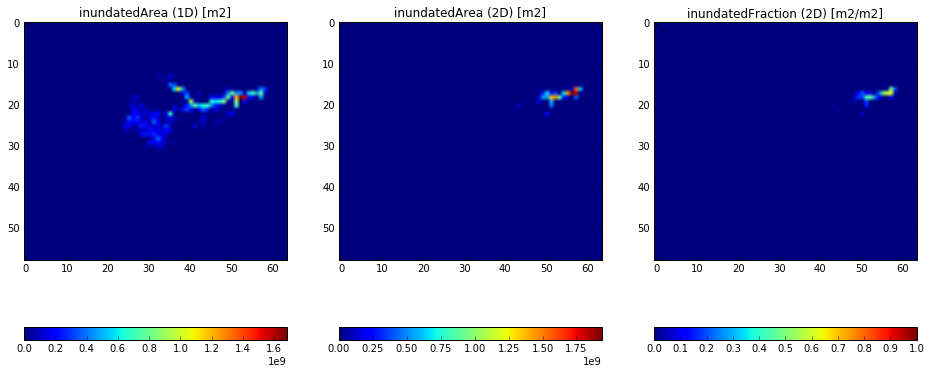

In [31]:
current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
current_water_depth_1D = current_water_depth[separator_1D:]
current_water_depth_2D = current_water_depth[:separator_1D]

inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               cellarea_data_pcr,
                                                                                               landmask_pcr)

inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

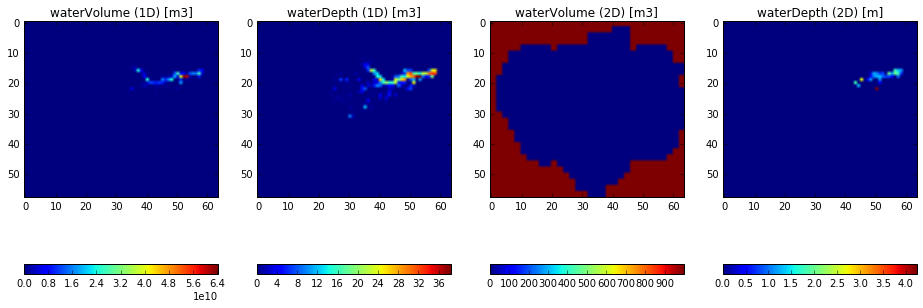

In [32]:
current_water_volume = np.copy(hydrodynamicModel.get_var('vol1'))
current_water_volume_1D = current_water_volume[separator_1D:]
current_water_volume_2D = current_water_volume[:separator_1D]

waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
# plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

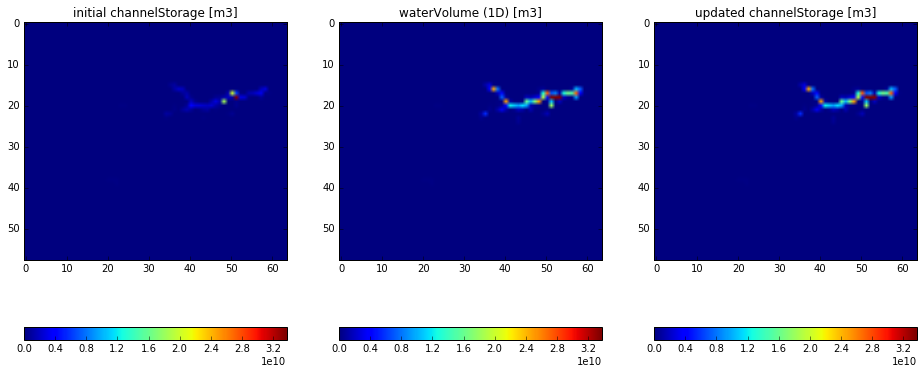

In [33]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [34]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

max fWL 4.23892306981


In [35]:
model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

hydrologicModel.update(1)

2018-02-21 13:57:52,223 model.pcrglobwb INFO Reading forcings for time 1984-01-02
2018-02-21 13:57:53,036 model.pcrglobwb INFO Updating model for time 1984-01-02
2018-02-21 13:57:53,048 model.landSurface INFO Updating land cover: forest
2018-02-21 13:57:53,051 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/Global_CropCoefficientKc-Forest_30min.nc ; variable: kc !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-21 13:57:53,318 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/interceptCapInputForest366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-21 13:57:53,588 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/coverFractionInputForest366days.nc ; variable: cov

In [36]:
delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)


delta volume of all PCR cells before feedback from DFM: 2.59E+10
feedback volume from FM: 1.30E+06 
delta volume of all PCR cells after feedback from DFM: 2.59E+10
reduction by  0.01 %
delta volume for PCR cells coupled to hydrodynamic channels 2.14E+10


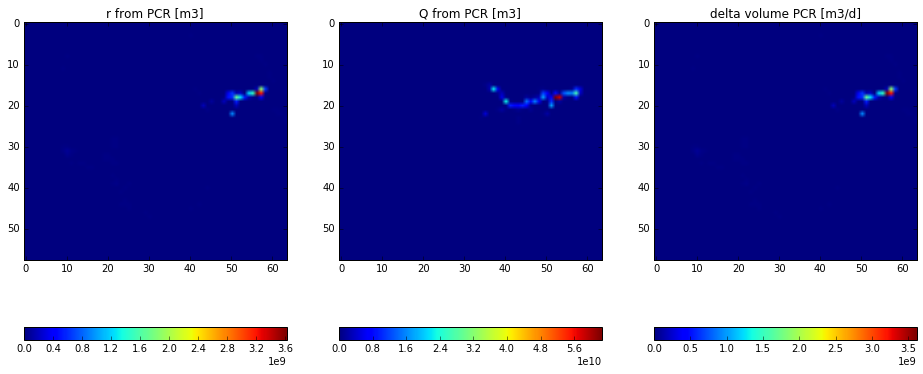

In [37]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = 0.
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = 0.

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [38]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

In [40]:
execute_all = False

In [41]:
if execute_all == True:

    while hydrologicModel.get_time_step() < end_time_pcr:

        current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
        current_water_depth_1D = current_water_depth[separator_1D:]
        current_water_depth_2D = current_water_depth[:separator_1D]

        inundatedArea_HDYN1D_2_HLOG, \
            inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                                       coupled_HLOG_indices,
                                                                                                       current_water_depth_1D,
                                                                                                       threshold_inundated_depth,
                                                                                                       cellAreaSpherical_1D,
                                                                                                       landmask_pcr)

        inundatedArea_HDYN2D_2_HLOG, \
            inundatedArea_HDYN2D_2_HLOG_BMI, \
                inundatedFraction_HDYN2D_2_HLOG, \
                    inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                                   coupled_HLOG_indices_2way,
                                                                                                                   current_water_depth_2D,
                                                                                                                   threshold_inundated_depth,
                                                                                                                   cellAreaSpherical_2D,
                                                                                                                   cellarea_data_pcr,
                                                                                                                   landmask_pcr)

        current_water_volume = np.copy(hydrodynamicModel.get_var('vol1'))
        current_water_volume_1D = current_water_volume[separator_1D:]
        current_water_volume_2D = current_water_volume[:separator_1D]

        waterVolume_HDYN1D_2_HLOG,\
            waterVolume_HDYN1D_2_HLOG_BMI,\
                waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                                  inundatedArea_HDYN1D_2_HLOG,
                                                                                                  current_water_volume_1D,
                                                                                                  couple_HLOG_2_HDYN,
                                                                                                  coupled_HLOG_indices, 
                                                                                                  landmask_pcr)

        waterVolume_HDYN2D_2_HLOG_BMI,\
            waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                              inundatedArea_HDYN2D_2_HLOG,
                                                                                              waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                              couple_HLOG_2_HDYN_2way,
                                                                                              coupled_HLOG_indices_2way,
                                                                                              landmask_pcr)

        ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

        if couple_channelStorage == False:
            waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

        model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

        model_functions.updateHydrologicVariables(hydrologicModel,
                                                  waterDepth_HDYN2D_2_HLOG_BMI,
                                                  inundatedFraction_HDYN2D_2_HLOG_BMI)

        model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

        hydrologicModel.update(1)

        delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                        missing_value_pcr, 
                                                                                        secPerDay, 
                                                                                        coupled_HLOG_indices, 
                                                                                        cellarea_data_pcr, 
                                                                                        waterVolume_HDYN2D_2_HLOG_BMI)

        delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                            couple_HDYN_2_HLOG, 
                                                                                            couple_HLOG_2_HDYN,
                                                                                            coupled_HLOG_indices,
                                                                                            delta_volume_PCR_1way, 
                                                                                            cellAreaSpherical_1D, 
                                                                                            fraction_timestep, 
                                                                                            model_type, 
                                                                                            use_Fluxes)

        model_functions.updateModel(hydrodynamicModel, 
                                    delta_water_DFM_1way, 
                                    update_step, 
                                    separator_1D, 
                                    use_Fluxes, 
                                    use_RFS, 
                                    model_type, 
                                    verbose)


    hydrodynamicModel.finalize()
    hydrologicModel.finalize()